# Building Good Training Datasets - Data Preprocessing
Un modelo perfecto no sirve de nada si los dato que lo alimentan son de mala calidad. Por eso es de increible importancia entender y estudiar el proceso por el cual debe pasar un dataset antes de pasar por un algoritmo de ML. 

En este capitulo se discutiran las cuestiones escenciales de **pre procesamineto** por las cuales deberia pasar un dataset para poder construir buenos modelo.

Algunos de los  topicos que se veran en este capitulo son:
- Remover e imputar valores faltantes en un dataset
- Transformar informacion categorica en una forma que un algoritmo de ML pueda utilizar
- Feature engineer y feature seleccion

## Trabajar con informacion faltante.
Es normal que en la data de la vida real falte informacion en algunos campos por varias razones. Desde errores en la recoleccion de datos, errores en el input de los datos o incluso simplente que venga vacio es una posibilidad.
En general en los datasets estos valores apareceran como _NaN_, _Null_ o _None_. Sin embargo muchos algortimso no estan preprarados para manejar este tipo de data o las predicciones nacidas a partir de este tipo de informacion podria no ser confiable. En esta seccion veremos algunas estrategias para poder manejar este tipo de valores


### Identifying missin values in tabular data
Antes de discutir como manejar este tipo de datos, veamos un ejemplo sencillo de un DataFrame a partir de un CSV para visualizar el problema

In [75]:
import pandas as pd
from io import StringIO
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [76]:
# En el caso mostrado es facil identificar los nulos,pero en dataframes mas grandes es directmente imposible.
# Por suerte podemos usar funciones para facilitar esto.
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

### Eliminating training examples or features with missing values
Una de las formas mas faciles de remover nulos es directamente removiendo la columna o fila por completo. Esta no es la mejor forma por razones obvias.

In [77]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [78]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [79]:
# Tambien hay un metodo que elimina solo si todas las columnas son NaN
df.dropna(how='all')


,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [80]:
# drop rows that have fewer than 4 real values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


### Imputing missing values
Muchas veces no se utiliza la opcion de droppear valores ya que podriamos terminar perdiendo mucha informacion valiosa. Por lo que otra alternativa muy comun es el de remplazas los valores faltantes por otro valor. 

Este metodo es muy delicado y hay varias maneras de hacerlo. Una de ellas es **mean imputation** donde remplazamos el valor faltante por el valor medio de la feature completa. Con skckit lear esto puede hacerse mediante la clase _SimpleImputer_

In [81]:
from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.nan,strategy= 'mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

Otra estrategia muy comun es la de _most-frequent_, donde remplazamos el valor de nulo por el valor mas frecuente de la feture (mode). Este metodo es muy utilizado en features categoricas.

Otra forma directa es utilizar el metodo _fillna_ de pandas.

In [82]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


## Handling categorical data
Hasta ahora solo trabajamos con valores numericos. Sin embargo es muy comun que en datos del mundo real tambien haya una o mas features categoricas. En esta seccion veremos algunas tecnicas simples para poder trabajar con este tipo de features.

Dentro de las features categoricas tenemos las **ordinales** y las **nominales**. Las ordianales son las features que poseen algun sentido de orden o jerarquia, por ejemplo los talles de ropa _XL_ > _L_ > _M_. Mientras que las nominales no poseen un orden asociado, como los colores.

### Categorical data encoding with pandas.
Antes de empezar a ver tecnicas, creemos un df de python con un ejemplo para ilustrar el problema que tenemos que resolver

In [83]:
import pandas as pd
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class2'],
    ['red', 'L', 13.5, 'class1'],
    ['blue', 'XL', 15.3, 'class2']
])

df.columns = ['color','size','price','classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


Vemos que el df creado tiene una categoria nominal (color), una categoria oridnal (tamaño) y una feature numerica (precio). El tag de clase (asumiendo que el dataset esta creado para aprendizaje supervisado) se guarda en la ultima columna.

### Mapping ordinal fetures
Para asegurarnos de que el algoritmo interpreta bien las features ordinales, necesitamos convertir las categorias en integers. Lamentablemente no existe una funcion que pueda automaticamente hacer este tipo de conversion conservando el orden.

Por esto es necesario hacer un mapeo entre las features y su valor asociado como se muestra a continuacion

In [84]:
size_mapping = {
    'XL' : 3,
    'L' : 2,
    'M' : 1
}

In [85]:
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [86]:
#Tambien es posible hacer un mapeo inverso para recobrar las features originales
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### Encoding class labels
Muchas librerias de machine learning requieren que los labels de las clases esten decodificados como valores integers. Aunque muchos estiamdores para clasificacion convierten los labels a integer manualmente, se consideraq una buena practica hacerlo de antemano para evitar errores tecnicos.

Para trabajar con varaibles categoricas no hace falta hacer un mapeo ya que no es necesario conservar una nocion de orden.

In [87]:
import numpy as np
class_mapping = {label : idx for idx, label in
                 enumerate(np.unique(df['classlabel']))
}
class_mapping

{'class1': 0, 'class2': 1}

In [88]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [89]:
# De manera alternativa hay una clase muy conveniente en skict lear llamda LabelEncoder
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1], dtype=int64)

In [90]:
#Tambien viene incluido un metodo de inversa
class_le.inverse_transform(y)

array([1, 0, 1], dtype=int64)

### Perfmorming one-hot encoding on nominal features
El problema con este aproach es el siguiente, y es que _LabelEncoder_ lo que hace es a cada tipo de clase dentro de uan feature le asigna un valor de $1$ a $n$. Sin embargo muchos algoritmos de ML tomaran cualquiera valor mayor a $1$ como un signo de que esa categoria tiene orden.

Una tecnica muy comun de solventar este problema es con la tecnica de **one-hot encoding**. La idea es que creamos una feature dummy para cada valor unico en la clase nomial de la siguiente manera

In [91]:
from sklearn.preprocessing import OneHotEncoder
X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:,0].reshape(-1,1)).toarray()


array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [92]:
from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([
      ('onehot', OneHotEncoder(), [0]),
      ('nothing', 'passthrough', [1, 2])
  ])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

Un detalle muy importante es que al usar OHE estamos introduciendo colinearidad en el dataset, lo cual es relevante ya que algunos algortimos utilizan inversiones de matrices. El tener alto correlacion entre las columnas hace que sea muy caro computacionalmente invertirlas y vuleve los resultados inestables. Una forma de reducir esto es quedarse con $n-1$ dummy features en lugar de $n$.

In [93]:
# Como dropear un valor usando OHE
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([
             ('onehot', color_ohe, [0]),
             ('nothing', 'passthrough', [1, 2])
  ])

#### Additional encoding schemes for nominal data
OHE no es la unica manera que tenemos de labelear la data, existen otros metodos para trabajar con, por ejemplo, datos que tienen una alta cardinalidad.
- Binary encoding (buscar)
- Count of frecuency encoding


## Partitioning a dataset into seprate training and test datasets

In [94]:
#En esta seccion vamos y en lo que queda del capitul vamos a trabajar con el dataset de vinos disponible
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                        'ml/machine-learning-databases/'
                        'wine/wine.data', header=None)

In [95]:
df_wine.columns = ['Class label', 'Alcohol',
                     'Malic acid', 'Ash',
                     'Alcalinity of ash', 'Magnesium',
                     'Total phenols', 'Flavanoids',
                     'Nonflavanoid phenols',
                     'Proanthocyanins',
                     'Color intensity', 'Hue',
                     'OD280/OD315 of diluted wines',
                     'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Tenemos 13 diferentes features in el dataset de vinos. Vemos que los ejemplos perteneces a una de tres diferentes clases. 

Una manera conveniente de separar de manera aleatoria es usando el metodo *train_test_split* del modulo *model_selection* de scikit learn.

In [96]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test =\
train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

Empezamos separando las fetures de la clase asociada y luego usamos *train_test_split* para hacer una distribucion random del X e y en datasets de entrenamiento y testeo. El argumento **stratify** nos asegura que ambos datasets tendran la misma proporcion de clases que el dataset original.

## Bringin fetures onto the same scale
Feature scaling es un paso crucial en el pipeline de preprocesamineto que muchas veces puede ser olvidado. Hay pocos algoritmos donde esto no es tan imporatne como arboldes de decisicion y random forest ya que son de escala invariante. Sin embargo la mayoria de los algortimos que hoy se usan no lo son y es necesario que las features se encuentren en la misma escala.

Hay dos aproachs muy comunes para escalear las features: **normalizacion** y **estandarizacion**. 

En general, la normalizacion involucra transformar nuestras features a uan escala con un rango $[0,1]$. Donde cada valor nuevo se calcula como

$$
x^{i}_{norm} = \frac{x^{i}-x_{min}}{x_{max}-x_{min}}
$$

En scikit lear podemos aplicarlo usando el modulo *MinMaxScaler*

In [97]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

Si bien la normalizacion es una tecnica usada, la estandarizacion suele ser mas practica para muchos algoritmos de machine learning. Especialmente los que requieren algun tipo de optimizacion. Esto se debe a que muchos algoritmos inician con los valores cercanos a 0 o en valores muy pequeños. Usando estandarizacion lo que estamos haciedno es convertir nuestra feature en una nueva de media 0 y desviancion estandar 1.

Algo importante es que la estsandarizacion NO modifica la distribucion de los datos, por lo tanto los datos que no tienen distribucion normal seguiran sin tenerla luego de la estandarizacion. 

La estandarizacion para un caso $x^{i}$ puede calcularse como:

$$
x^{i}_{std} = \frac{x^{i}-\mu_{x}}{\sigma_{x}}
$$

In [98]:
# En scikit learn
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Selecting meaninful features
Si vemos que el modelo funciona mucho mejor en el set de entranamiento que en el set de test, esto podria indicar un caso de overfitting. Esto ocurre porque el modelo aprende de forma muy rigurosa los valores especificos del dataset de entramiento y no puede generalizar correctamente, lo que termina con un modelo con una **alta varianza**. En genearl el overfitting puede ocurrir porque el modelo es muy complejo para los datos disponibles. Soluciones communes a este problema suelen ser:
- Mas data
- Regulizar para penalizar la complejidad
- Seleccionar un modelo mas simple
- Reducir la dimensionalidad de los datos

Muchas veces la recoleccion de mas data no es posible, en el capitulo 6 aprendemos sobre tecnicas utiles para chequear si la la informacion dada por el set de entramiento es buena. En la siguientes secciones veremos maneras de reducir el overfitting mediante regularizacion y reduccion de dimensioanlidad.

### L1 y L2 regularizaciones como penalizacion de modelos complejos
Como mencionamos en el capitulo 3, la regularizcion L2 es un camino para poder reducir la compejidad del modelo que penaliza pesos individuales que posean valores muy altos. Se definio la norma L2 para cada peso como

$$
||w||^{2}_{2}= \sum_{j=1}^{m}w_{j}^{2}
$$

Otro camino es la regularizacion L1:

$$
||w||_{1}= \sum_{j=1}^{m}|w_{j}|
$$

Donde se cambia la suma del cuadrado de lso pesos por la suma del valor absoluto de cada valor. A diferencai de la regularizacion L2, la regularizacion L1 en general posee valores mas esparcidos y muchos pesos seran 0. En general esto es deseado cuando tenemos un dataset con alta dimensionalidad, pero donde la gran mayoria de las features son irrelevantes.

### Interpretacion geometrica de la regularizacion L2

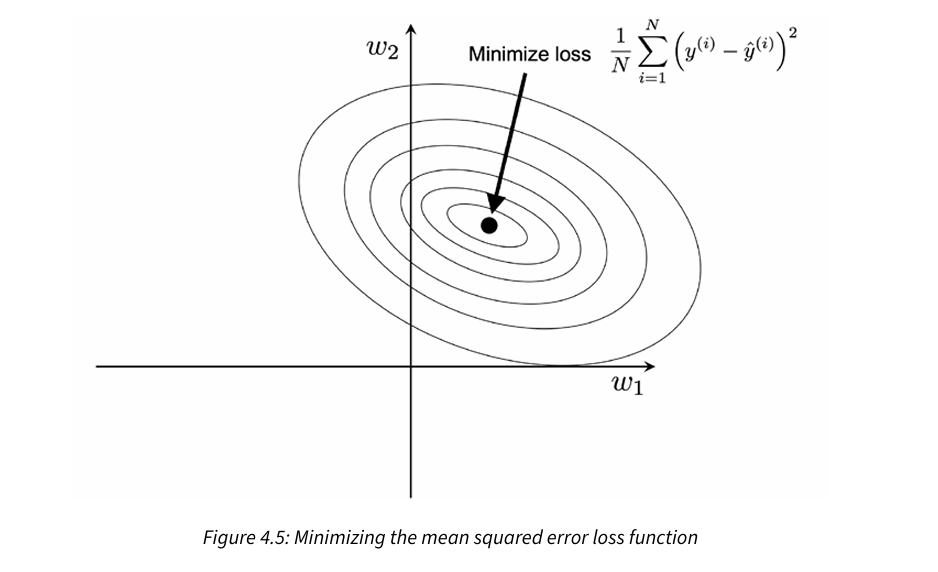

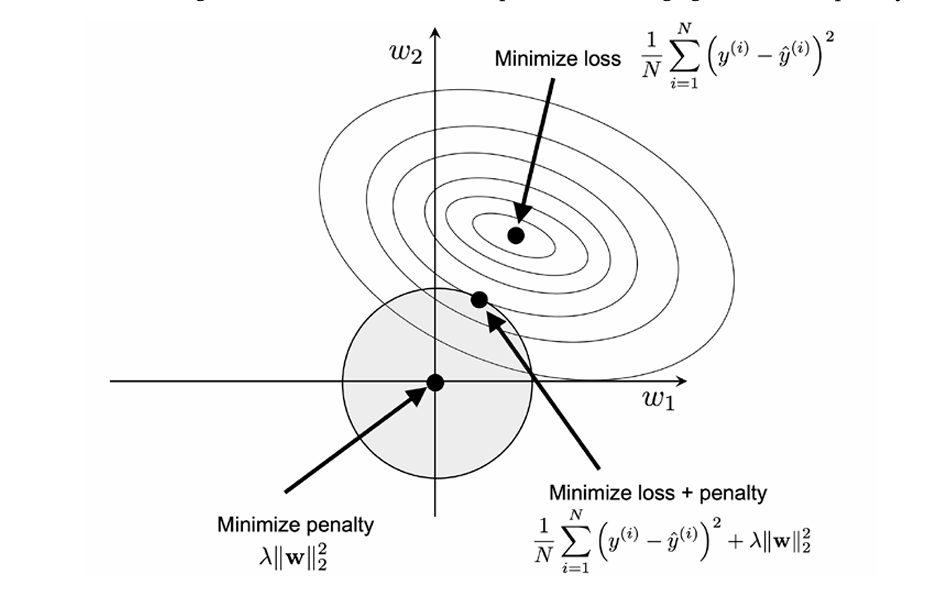

### Sparse solutions with L1 regulariztion

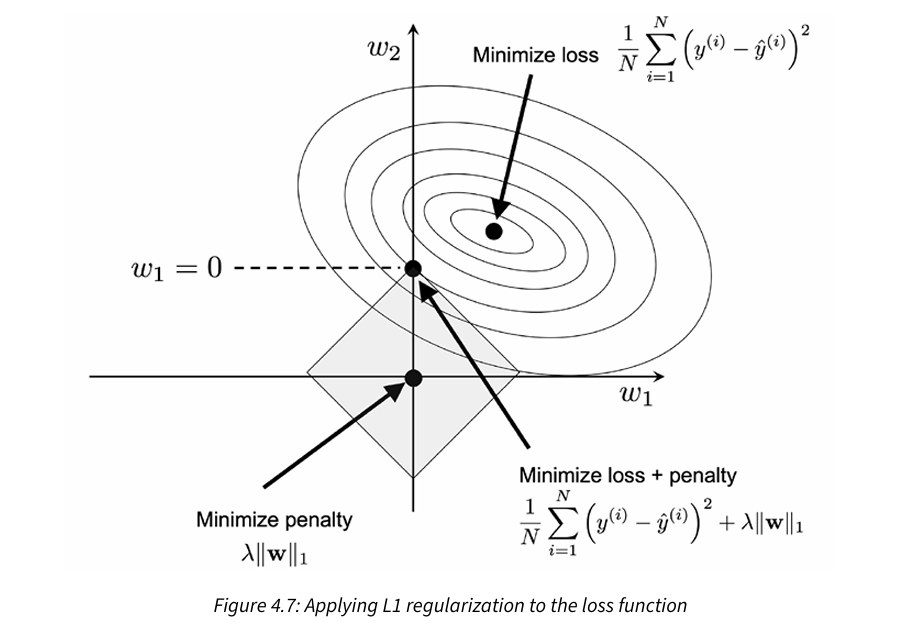

In [99]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1',
                     solver='liblinear',
                     multi_class='ovr')

LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

In [100]:
lr = LogisticRegression(penalty='l1',
                          C=1.0,
                          solver='liblinear',
                          multi_class='ovr')
  # Note that C=1.0 is the default. You can increase
  # or decrease it to make the regularization effect
  # stronger or weaker, respectively.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))

Training accuracy: 1.0


c:\Users\ivanl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [101]:
lr.intercept_

array([-1.26336435, -1.21603887, -2.37023105])

#### Accessing the bias unit and weight parameters of scikit-learn estimators
 In scikit-learn, intercept_ corresponds to the bias unit and coef_ corresponds to the 
values wj.

Un punto importante es que la regularizacion L1 puede usarse tambien para eliminar features irrelevante para el proyecto

### Sequeantial feature selection algorithms
Otra forma de reducir la complejidad del modelo es mediante **reduccion de dimensioanlidad** mediante feature selection y feature extraccion. En feature selection, seleccionamos un subset del dataset origina, mientras que en feature extraction, derivamos informacion del set de features para construir un nuevo subset.

En este capitulo se vera a una seleccion clasica de algoritmos para feature selection. En el capitulo siguiente se veran los diferentes tipos de tecnicas para realizar feture extraccion.

Un algoritmos clasico secuancial de seleccion es el conocido como **sequiential backward selection (SBS)**, el cual apunta a reducir la dimensioanldiad del dataset inicial con un minimo decaimiento en la perfomance computacional.

Lo que busca el algoritmos SBS es minimzar alguna funcion de criterio $J$
 1. Initialize the algorithm with k = d, where d is the dimensionality of the full feature space, Xd.
 2. Determine the feature, x–, that maximizes the criterion: x– = argmax J(Xk – x), where 𝒙𝒙𝒙𝒙𝒙𝑘𝑘 .
 3. Remove the feature, x–, from the feature set: Xk–1 = Xk – x–; k = k – 1.
 4. Terminate if k equals the number of desired features; otherwise, go to step 2


In [102]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
    def __init__(self, estimator, k_features,
                 scoring = accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
                    scores = []
                    subsets = []

                    for p in combinations(self.indices_, r=dim - 1):
                        score = self._calc_score(X_train, y_train,
                                                 scores.append(score),
                                                 subsets.append(p))
                        
                        best = np.argmax(scores)
                        self.indices_ = subsets[best]
                        self.subsets_.append(self.indices_)
                        dim -= 1
                        self.scores_.append(scores[best])
                    self.k_score_ = self.scores_[-1]
                    return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

## Assesing feature importance with random forest
En secciones previas aprednimos como usar la regularicion L1 para llevar a 0 features irrelevantes con mediante la regresion logistica y ocmo usar el algoritmos SBS para aplicar feature selection i aplicarsela a un algoritmos KNN.

Otro aproach muy util para seleccionar faetures relevantes de un dataset es el de usar un **random forest**, una tecnica de ensambles que se introdujo en el campitulo 3. Usando random forest poder medir la importancia de cada feature como el promedio del decresimiento de la impureza computada para todos los arboles de desicion en el bosque, sin aser ninguna hipotesis sobre nuestra data. De manera conveniente, la implementacion de random forest de scikit learn ya viene con un metodo llamdo *feature_importances_atribbute* disponible luego de ajustar con RandomForestClassifier. Con el siguiente codigo, entrenaremos 500 arboles en el dataset de vinos y ranquearemos las 13 fetures de acerudo a su medida de importancia.

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


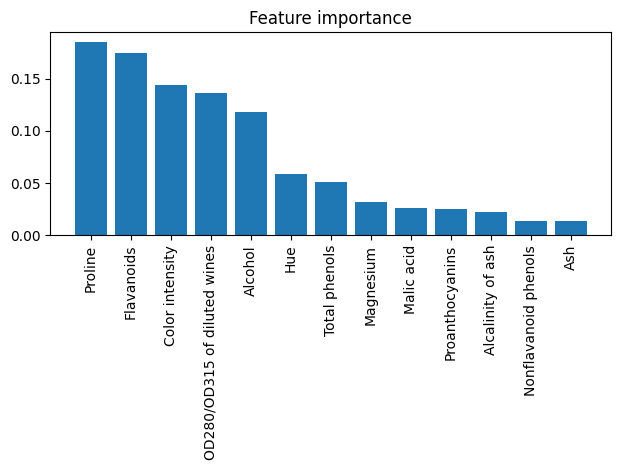

In [105]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

feat_labels= df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                              feat_labels[indices[f]],
                              importances[indices[f]]))
    
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]),
          importances[indices],
          align='center')
plt.xticks(range(X_train.shape[1]),
             feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Algo importante con respecto a la interpretabilidad de este metodo, es que si dos o mas variables estan altamente correlacioandas, one feature podria estar rankeada muy alto mientras que la ifnromacion de las otras features podria no estar complemente representada. Esto no es tanto un problema para la perfomance del algoritmo, sino mas si buscamos centrarnos en la interpretabildiad de la feature importance.

